In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### 1. Single-image Dataset

In [7]:
class SingleODOCSegmentationDataset(Dataset):
    def __init__(self, image_path, mask_path, mask_key='mask'):
        self.image_path = image_path
        self.mask_path = mask_path
        self.mask_key = mask_key

    def __len__(self):
        return 1  # only one sample

    def __getitem__(self, idx):
        image = Image.open(self.image_path).convert('RGB')
        mat = loadmat(self.mask_path)
        mask = mat[self.mask_key].astype(np.uint8)  # 0=bg, 1=OD, 2=OC
        # Resize mask if needed
        if mask.shape != image.size[::-1]:
            mask = Image.fromarray(mask)
            mask = mask.resize(image.size, resample=Image.NEAREST)
            mask = np.array(mask)
        # To tensor
        image = np.array(image).transpose(2,0,1) / 255.0
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask


### 2. Pick one sample

In [8]:

img_path = 'ORIGA/ORIGA/roi_images/001.jpg'
mask_path = 'ORIGA/ORIGA/Semi-automatic-annotations/001.mat'
dataset = SingleODOCSegmentationDataset(img_path, mask_path)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

### 3. Model: ResNet34 U-Net

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Classes: 0=bg, 1=OD, 2=OC
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,   # train from scratch for overfitting
    in_channels=3,
    classes=3
).to(device)

### 4. Loss, Optimizer

In [10]:
# Class weights for extreme imbalance, e.g. [1.0, 30.0, 50.0], or compute from all data
class_weights = torch.tensor([1.0, 30.0, 50.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 5. Overfit on One Image

In [13]:
model.train()
losses = []
for epoch in range(20):
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 20, Loss: 0.0048


### 6. Visualize Prediction, Ground Truth, Input

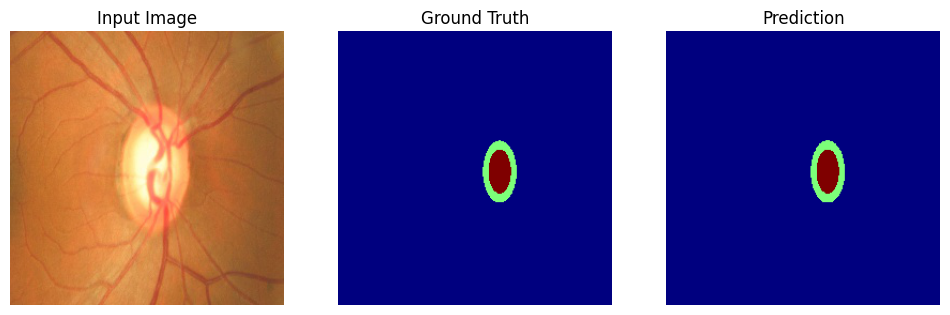

In [12]:
model.eval()
with torch.no_grad():
    for images, masks in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu()
        images = images.cpu()
        masks = masks.cpu()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(images[0].permute(1,2,0))
        plt.title('Input Image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(masks[0], cmap='jet', vmin=0, vmax=2)
        plt.title('Ground Truth')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(preds[0], cmap='jet', vmin=0, vmax=2)
        plt.title('Prediction')
        plt.axis('off')
        plt.show()